In [13]:
import numpy as np
import pandas as pd

-f
Indexing word vectors.
Processing text dataset
Found 10020 texts.
Found 18098 unique tokens.
Shape of data tensor: (10020, 1)
Shape of label tensor: (10020, 12)
Preparing embedding matrix.
Training model.


C:\Users\wangs\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8064 samples, validate on 986 samples
Epoch 1/100
8064/8064 [==============================] - 3s 427us/step - loss: 0.6785 - binary_accuracy: 0.5422 - val_loss: 0.6599 - val_binary_accuracy: 0.5622
Epoch 2/100
8064/8064 [==============================] - 2s 200us/step - loss: 0.6353 - binary_accuracy: 0.5668 - val_loss: 0.6055 - val_binary_accuracy: 0.6344
Epoch 3/100
8064/8064 [==============================] - 2s 211us/step - loss: 0.5796 - binary_accuracy: 0.7013 - val_loss: 0.5495 - val_binary_accuracy: 0.7098
Epoch 4/100
8064/8064 [==============================] - 2s 229us/step - loss: 0.5262 - binary_accuracy: 0.8109 - val_loss: 0.4980 - val_binary_accuracy: 0.8950
Epoch 5/100
8064/8064 [==============================] - 2s 214us/step - loss: 0.4776 - binary_accuracy: 0.8936 - val_loss: 0.4523 - val_binary_accuracy: 0.8950
Epoch 6/100
8064/8064 [==============================] - 2s 214us/step - loss: 0.4350 - binary_accuracy: 0.8936 - val_loss: 0.4131 - val_binary_accu

8064/8064 [==============================] - 2s 220us/step - loss: 0.2839 - binary_accuracy: 0.8936 - val_loss: 0.2866 - val_binary_accuracy: 0.8950
Epoch 52/100
8064/8064 [==============================] - 2s 221us/step - loss: 0.2839 - binary_accuracy: 0.8936 - val_loss: 0.2866 - val_binary_accuracy: 0.8950
Epoch 53/100
8064/8064 [==============================] - 2s 205us/step - loss: 0.2838 - binary_accuracy: 0.8936 - val_loss: 0.2866 - val_binary_accuracy: 0.8950
Epoch 54/100
8064/8064 [==============================] - 2s 202us/step - loss: 0.2838 - binary_accuracy: 0.8936 - val_loss: 0.2866 - val_binary_accuracy: 0.8950
Epoch 55/100
8064/8064 [==============================] - 2s 201us/step - loss: 0.2838 - binary_accuracy: 0.8936 - val_loss: 0.2866 - val_binary_accuracy: 0.8950
Epoch 56/100
8064/8064 [==============================] - 2s 210us/step - loss: 0.2838 - binary_accuracy: 0.8936 - val_loss: 0.2865 - val_binary_accuracy: 0.8950
Epoch 57/100
8064/8064 [=================

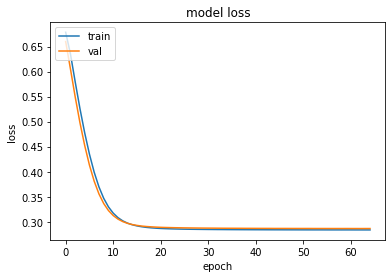

In [16]:
# %load blstm.py

from __future__ import print_function
# coding: utf-8

# In[1]:


import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"


# In[2]:



# import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional, LSTM
from keras.models import Model
from custom_metrics import hamming_score, f1

from keras.callbacks import EarlyStopping
# import matplotlib.pyplot as plt
import logging, pickle

print(sys.argv[1])
lstm_units = 1 #int(sys.argv[1])
dropout_rate = 1 # float(sys.argv[2])
dense_units = 1 # int(sys.argv[3])
max_len = 1  # int(sys.argv[4])
# In[3]:

logging.basicConfig(filename='res/blstm/{}_{}_{}_{}.log'.format(lstm_units, dropout_rate, dense_units, max_len), level=logging.INFO)

# In[3]:


BASE_DIR = ''
GLOVE_DIR = ''
# EMBEDDING_FILE = 'glove.6B.100d.txt'
EMBEDDING_FILE = ''
MAX_SEQUENCE_LENGTH = max_len
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
EMBED_INIT_GLOVE = False


# In[4]:


train_file = '../data/msdialog/train.tsv'
valid_file = '../data/msdialog/valid.tsv'
test_file = '../data/msdialog/test.tsv'


# In[5]:


# first, build index mapping words in the embeddings set to their embedding vector

print('Indexing word vectors.')

# embeddings_index = {}
# with open(os.path.join(GLOVE_DIR, EMBEDDING_FILE)) as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

# print('Found %s word vectors.' % len(embeddings_index))


# In[6]:


# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {'OQ': 0, 'RQ': 1, 'FQ': 2, 'IR': 3, 'PF': 4, 'NF': 5, 'O': 6, 'PA': 7, 'GG': 8, 'FD': 9, 'CQ': 10, 'JK': 11}
id2label = {v: k for k, v in labels_index.items()}
classes_num = len(labels_index)

def load_data_and_labels(data_file):
    x = []
    y = []
    i = 0
    with open(data_file) as raw_data:
        for line in raw_data:
            i += 1
#             print(i)
            if line != '\n':
                line = line.strip()
                tokens = line.split('\t')
                labels = tokens[0].split('_')
                x.append(tokens[1])
                each_y = [0] * classes_num
                for label in labels:
                    each_y[labels_index[label]] = 1
                y.append(each_y)
    return x, y

x_train, y_train = load_data_and_labels(train_file)
x_valid, y_valid = load_data_and_labels(valid_file)
x_test, y_test = load_data_and_labels(test_file)
# MAX_SEQUENCE_LENGTH = max(max(map(len, x_train)), max(map(len, x_valid)), max(map(len, x_test)))
# print(MAX_SEQUENCE_LENGTH)
labels = np.array(y_train + y_valid + y_test)

print('Found %s texts.' % len(x_train + x_valid + x_test))


# In[7]:


# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x_train + x_valid)
sequences = tokenizer.texts_to_sequences(x_train + x_valid + x_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# labels = to_categorical(np.asarray(y_train))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


# In[8]:


print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)

if EMBED_INIT_GLOVE:
    embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if i >= MAX_NUM_WORDS:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # load pre-trained word embeddings into an Embedding layer
    # note that we set trainable = False so as to keep the embeddings fixed
    embedding_layer = Embedding(num_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
else:
    embedding_layer = Embedding(num_words, 
                                EMBEDDING_DIM, 
                                embeddings_initializer='uniform', 
                                input_length=MAX_SEQUENCE_LENGTH)


# In[9]:


num_validation_samples = len(y_valid)
num_test_samples = len(y_test)
num_train_samples = len(y_train)
num_total_samples = len(labels)

x_train = data[:num_train_samples]
y_train = labels[:num_train_samples]
x_val = data[num_train_samples: num_train_samples + num_validation_samples]
y_val = labels[num_train_samples: num_train_samples + num_validation_samples]
x_test = data[-num_test_samples:]
y_test = labels[-num_test_samples:]

assert len(x_train) + len(x_val) + len(x_test) == len(labels)
assert len(y_train) + len(y_val) + len(y_test) == len(labels)


# In[10]:


print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(lstm_units))(embedded_sequences)
x = Dropout(dropout_rate)(x)
x = Dense(dense_units)(x)
preds = Dense(len(labels_index), activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

es = EarlyStopping(monitor='val_loss',
                  min_delta=0,
                  patience=2,
                  verbose=0, mode='auto')

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          callbacks=[es],
          validation_data=(x_val, y_val))


# In[11]:


import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


# In[12]:


def show_example(idx):
#     N_true = int(np.sum(y_test[idx]))
    N_true = 12
    print("Prediction: {}".format("|".join(["{} ({:.3})".format(id2label[s],
                                                                pred[idx][s])
                                            for s in pred[idx].argsort()[-N_true:][::-1]])))


# In[13]:
pred_val = model.predict(np.array(x_val))
pred_test = model.predict(np.array(x_test))
from copy import deepcopy
# In[ ]:
for th in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:

    pred = deepcopy(pred_val)




# In[14]:


# if predicted proba >= 0.5, this label is set to 1. if all probas < 0.5, the label with largest proba is set to 1
    for i in range(pred.shape[0]):
        if len(np.where(pred[i] >= th)[0]) > 0:
            pred[i][pred[i] >= th] = 1
            pred[i][pred[i] < th] = 0
        else:
            max_index = np.argmax(pred[i])
            pred[i] = 0
            pred[i][max_index] = 1


    acc_val = hamming_score(y_val, pred)
    p_val, r_val, f1_val = f1(y_val, pred)


    # In[ ]:
    pred = deepcopy(pred_test)



    for i in range(pred.shape[0]):
        if len(np.where(pred[i] >= th)[0]) > 0:
            pred[i][pred[i] >= th] = 1
            pred[i][pred[i] < th] = 0
        else:
            max_index = np.argmax(pred[i])
            pred[i] = 0
            pred[i][max_index] = 1

    acc_test = hamming_score(y_test, pred)
    p_test, r_test, f1_test = f1(y_test, pred)

    pickle_name = 'res/blstm/{}_{}_{}_{}_{}.res'.format(lstm_units, dropout_rate, dense_units, max_len, th)
    pickle_file = open(pickle_name, 'wb')
    pickle.dump(pred, pickle_file, pickle.HIGHEST_PROTOCOL)
    pickle_file.close()

    logging.info('{},{},{},{},{},{},{},{},{},{},{},{},{}'.format(
        lstm_units, dropout_rate, dense_units, max_len, th, acc_val, p_val, r_val, f1_val, acc_test, p_test, r_test, f1_test
    ))


In [9]:
array_f = '../data/Experiment/Valid_328853_34308.npy'
X = np.load(array_f)

In [10]:
X


array([[ 0.42388505, -0.00777789,  0.23651005, ..., -0.11761022,
         0.29358882,  0.3746736 ],
       [ 0.6072346 , -0.54473937,  0.6851583 , ..., -0.2108932 ,
         0.07921334,  0.33541626],
       [ 0.30296996, -0.30779636,  0.26667506, ...,  0.38648814,
         0.13085765,  0.8317897 ],
       ...,
       [ 0.7904673 ,  0.02980215,  0.4440329 , ...,  0.32058296,
        -0.05098233,  0.27760336],
       [ 0.5624872 ,  0.17496133, -0.11323217, ..., -0.32359922,
         0.57077616, -0.20259726],
       [ 0.472658  ,  0.27651823, -0.12045603, ..., -0.33342186,
         0.5865195 , -0.19277444]], dtype=float32)

In [11]:
X[1,:]

array([ 6.07234597e-01, -5.44739366e-01,  6.85158312e-01, -2.32821897e-01,
       -5.33920527e-01,  3.83219421e-01,  2.70928085e-01, -2.57108659e-02,
        1.21941991e-01, -1.34292078e+00, -3.29492897e-01,  4.10439998e-01,
        3.15013155e-02,  1.04366288e-01, -6.84510589e-01,  2.03647241e-02,
        8.85440335e-02,  7.52348185e-01,  1.14841349e-01, -3.55980337e-01,
       -1.31744534e-01, -3.90325248e-01,  1.13205063e+00, -2.42788464e-01,
       -3.05838615e-01,  2.36626968e-01,  4.73049402e-01, -1.25819575e-02,
       -1.03556991e+00, -3.36251855e-02,  3.91320169e-01,  9.93486121e-02,
       -4.84311461e-01,  1.17801145e-01, -6.42261028e-01, -1.57996103e-01,
        4.27277684e-01,  3.81359830e-02,  2.90774226e-01,  2.38268554e-01,
       -3.27565789e-01, -6.59237653e-02,  7.64864206e-01, -2.63270020e-01,
       -4.38236475e-01, -3.62743020e-01, -4.16132212e-01,  4.26907301e-01,
       -1.28081366e-01,  2.51143634e-01, -1.78008657e-02, -6.75877690e-01,
        5.27033627e-01, -

In [14]:
print(np.__version__)

1.16.5


In [15]:
print(pd.__version__)

0.25.1
